In [ ]:
import math
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, add, Input, concatenate, AveragePooling2D
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
%load_ext tensorboard
from datetime import datetime
from sklearn.metrics import precision_score,accuracy_score,recall_score,confusion_matrix

## Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
# Mean normalization
mean = np.mean(x_train, axis=(0,1,2,3))
x_train -= mean
x_test -= mean


169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
print(x_train.shape[-3:],y_train.shape)

(32, 32, 3) (50000, 100)


In [ ]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        zoom_range=0.2,
        fill_mode='nearest')
datagen.fit(x_train)

## Building the Model

In [ ]:
def inception_layerA(filter1,filter2_in,filter2_out,filter3_in,filter3_intm,filter3_out,filter4_out,inception_in):
  # 1x1
  m1 = Conv2D(filter1,kernel_size=(1,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(inception_in)   #without activation
  m1 = BatchNormalization()(m1)
  m1 = Activation('relu')(m1)   #while removing make sure to add activation to conv layer above

  # 3x3
  m2 = Conv2D(filter2_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  m2 = Conv2D(filter2_out,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m2)   #without activation
  m2 = BatchNormalization()(m2)
  m2 = Activation('relu')(m2)   #while removing make sure to add activation to conv layer above
  # 5x5
  m3 = Conv2D(filter3_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  m3 = Conv2D(filter3_intm,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)          #while removing make sure to add activation to conv layer above
  m3 = Conv2D(filter3_out,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)          #while removing make sure to add activation to conv layer above
  # MaxPool
  # m4 = MaxPool2D((3,3),strides = 1, padding = 'same')(inception_in)
  m4 = AveragePooling2D((3, 3), strides=1,padding = 'same')(inception_in)
  m4 = Conv2D(filter4_out,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(m4)
  # Filter Concatenate
  model = concatenate([m1,m2,m3,m4],axis=-1)
  return model

In [ ]:
def inception_layerB(filter1,filter2_in,filter2_out,filter3_in,filter3_intm,filter3_out,filter4_out,inception_in):
  # 1x1
  # m1 = Conv2D(filter1,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  m1 = Conv2D(filter1,kernel_size=(1,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(inception_in)   #without activation
  m1 = BatchNormalization()(m1)
  m1 = Activation('relu')(m1)   #while removing make sure to add activation to conv layer above

  # 3x3
  m2 = Conv2D(filter2_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  # m2_1 = Conv2D(filter2_out,kernel_size=(3,3),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(m2)
  m2 = Conv2D(filter2_out,kernel_size=(1,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m2)   #without activation
  m2 = BatchNormalization()(m2)
  m2 = Activation('relu')(m2)   #while removing make sure to add activation to conv layer above
  m2 = Conv2D(filter2_out,kernel_size=(3,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(m2)
  m2 = BatchNormalization()(m2)
  m2 = Activation('relu')(m2) 
  # 5x5
  m3 = Conv2D(filter3_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)

  m3 = Conv2D(filter2_out,kernel_size=(1,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)   #without activation
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)   #while removing make sure to add activation to conv layer above
  m3 = Conv2D(filter2_out,kernel_size=(3,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)
  m3 = Conv2D(filter3_out,kernel_size=(1,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)          #while removing make sure to add activation to conv layer above
  m3 = Conv2D(filter3_out,kernel_size=(3,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)   
  # MaxPool
  # m4 = MaxPool2D((3,3),strides = 1, padding = 'same')(inception_in)
  m4 = AveragePooling2D((3, 3), strides=1,padding = 'same')(inception_in)
  m4 = Conv2D(filter4_out,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(m4)
  # Filter Concatenate
  model = concatenate([m1,m2,m3,m4],axis=-1)
  return model

In [ ]:
def inception_layerC(filter1,filter2_in,filter2_out,filter3_in,filter3_intm,filter3_out,filter4_out,inception_in):
  # 1x1
  # m1 = Conv2D(filter1,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  m1 = Conv2D(filter1,kernel_size=(1,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(inception_in)   #without activation
  m1 = BatchNormalization()(m1)
  m1 = Activation('relu')(m1)   #while removing make sure to add activation to conv layer above

  # 3x3
  m2 = Conv2D(filter2_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  # m2_1 = Conv2D(filter2_out,kernel_size=(3,3),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(m2)
  m2_1 = Conv2D(filter2_out,kernel_size=(1,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m2)   #without activation
  m2_1 = BatchNormalization()(m2_1)
  m2_1 = Activation('relu')(m2_1)   #while removing make sure to add activation to conv layer above
  m2_2 = Conv2D(filter2_out,kernel_size=(3,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(m2)
  m2_2 = BatchNormalization()(m2_2)
  m2_2 = Activation('relu')(m2_2) 
  # 5x5
  m3 = Conv2D(filter3_in,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(inception_in)
  m3 = Conv2D(filter3_intm,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3 = BatchNormalization()(m3)
  m3 = Activation('relu')(m3)          #while removing make sure to add activation to conv layer above
  m3_1 = Conv2D(filter3_out,kernel_size=(1,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3_1 = BatchNormalization()(m3_1)
  m3_1 = Activation('relu')(m3_1)          #while removing make sure to add activation to conv layer above
  m3_2 = Conv2D(filter3_out,kernel_size=(3,1),padding='same',kernel_regularizer=regularizers.l2(0.001))(m3)
  m3_2 = BatchNormalization()(m3_2)
  m3_2 = Activation('relu')(m3_2)   
  # MaxPool
  # m4 = MaxPool2D((3,3),strides = 1, padding = 'same')(inception_in)
  m4 = AveragePooling2D((3, 3), strides=1,padding = 'same')(inception_in)
  m4 = Conv2D(filter4_out,kernel_size=(1,1),padding='same',activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(m4)
  # Filter Concatenate
  model = concatenate([m1,m2_1,m2_2,m3_1,m3_2,m4],axis=-1)
  return model

In [ ]:
def create_model():
    inp = Input(shape=x_train.shape[-3:])
    m1 = Conv2D(64,kernel_size= (7, 7), padding='same', strides=(2, 2),kernel_regularizer=regularizers.l2(0.001))(inp)
    m1 = BatchNormalization()(m1)
    m1 = Activation('relu')(m1)          #while removing make sure to add activation to conv layer above
    m1 = MaxPool2D((3, 3), strides=(2, 2), padding='same')(m1)
    m1 = Conv2D(192,kernel_size= (3, 3), padding='same', strides=(1, 1), activation='relu',kernel_regularizer=regularizers.l2(0.001))(m1)
    m1 = MaxPool2D((3, 3), strides=(2, 2), padding='same')(m1)
    # m1 = Conv2D(80,kernel_size= (3, 3), padding='same', strides=(1, 1), activation='relu',kernel_regularizer=regularizers.l2(0.001))(m1)

    m1 = inception_layerA(64,96,128,16,20,32,32,m1)
    m1 = inception_layerA(128,128,192,32,64,96,64,m1)

    m1 = MaxPool2D((3, 3), strides=(2, 2), padding='same')(m1)
    m1 = inception_layerB(192,96,208,16,32,48,64,m1)
    m1 = inception_layerB(160,112,224,24,56,64,64,m1)
    # m1 = inception_layerB(128,128,256,24,48,64,64,m1)

    # m1 = inception_layerB(112,144,288,32,48,64,64,m1)
    m1 = inception_layerB(256,160,320,32,64,128,128,m1)

    m1 = MaxPool2D((3, 3), strides=(2, 2), padding='same')(m1)
    # m1 = AveragePooling2D(pool_size=8, padding='same')(m1)     #trying this-------

    m1 = inception_layerC(256,160,320,32,64,128,128,m1)
    m1 = inception_layerC(384,192,384,48,64,128,128,m1)
    # m1 = GlobalAveragePooling2D()(m1)
    m1 = AveragePooling2D((7, 7), strides=(1, 1), padding='same')(m1)
    # m1 = Dropout(0.4)(m1)
    m1 = Flatten()(m1)
    m1 = Dense(100, activation='softmax')(m1)

    model = Model(inputs=inp,outputs=m1)
    return model

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 16, 16, 64)   256         conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 16, 16, 64)   0           batch_normalization_112[0][0]    
_______________________________________________________________________________________

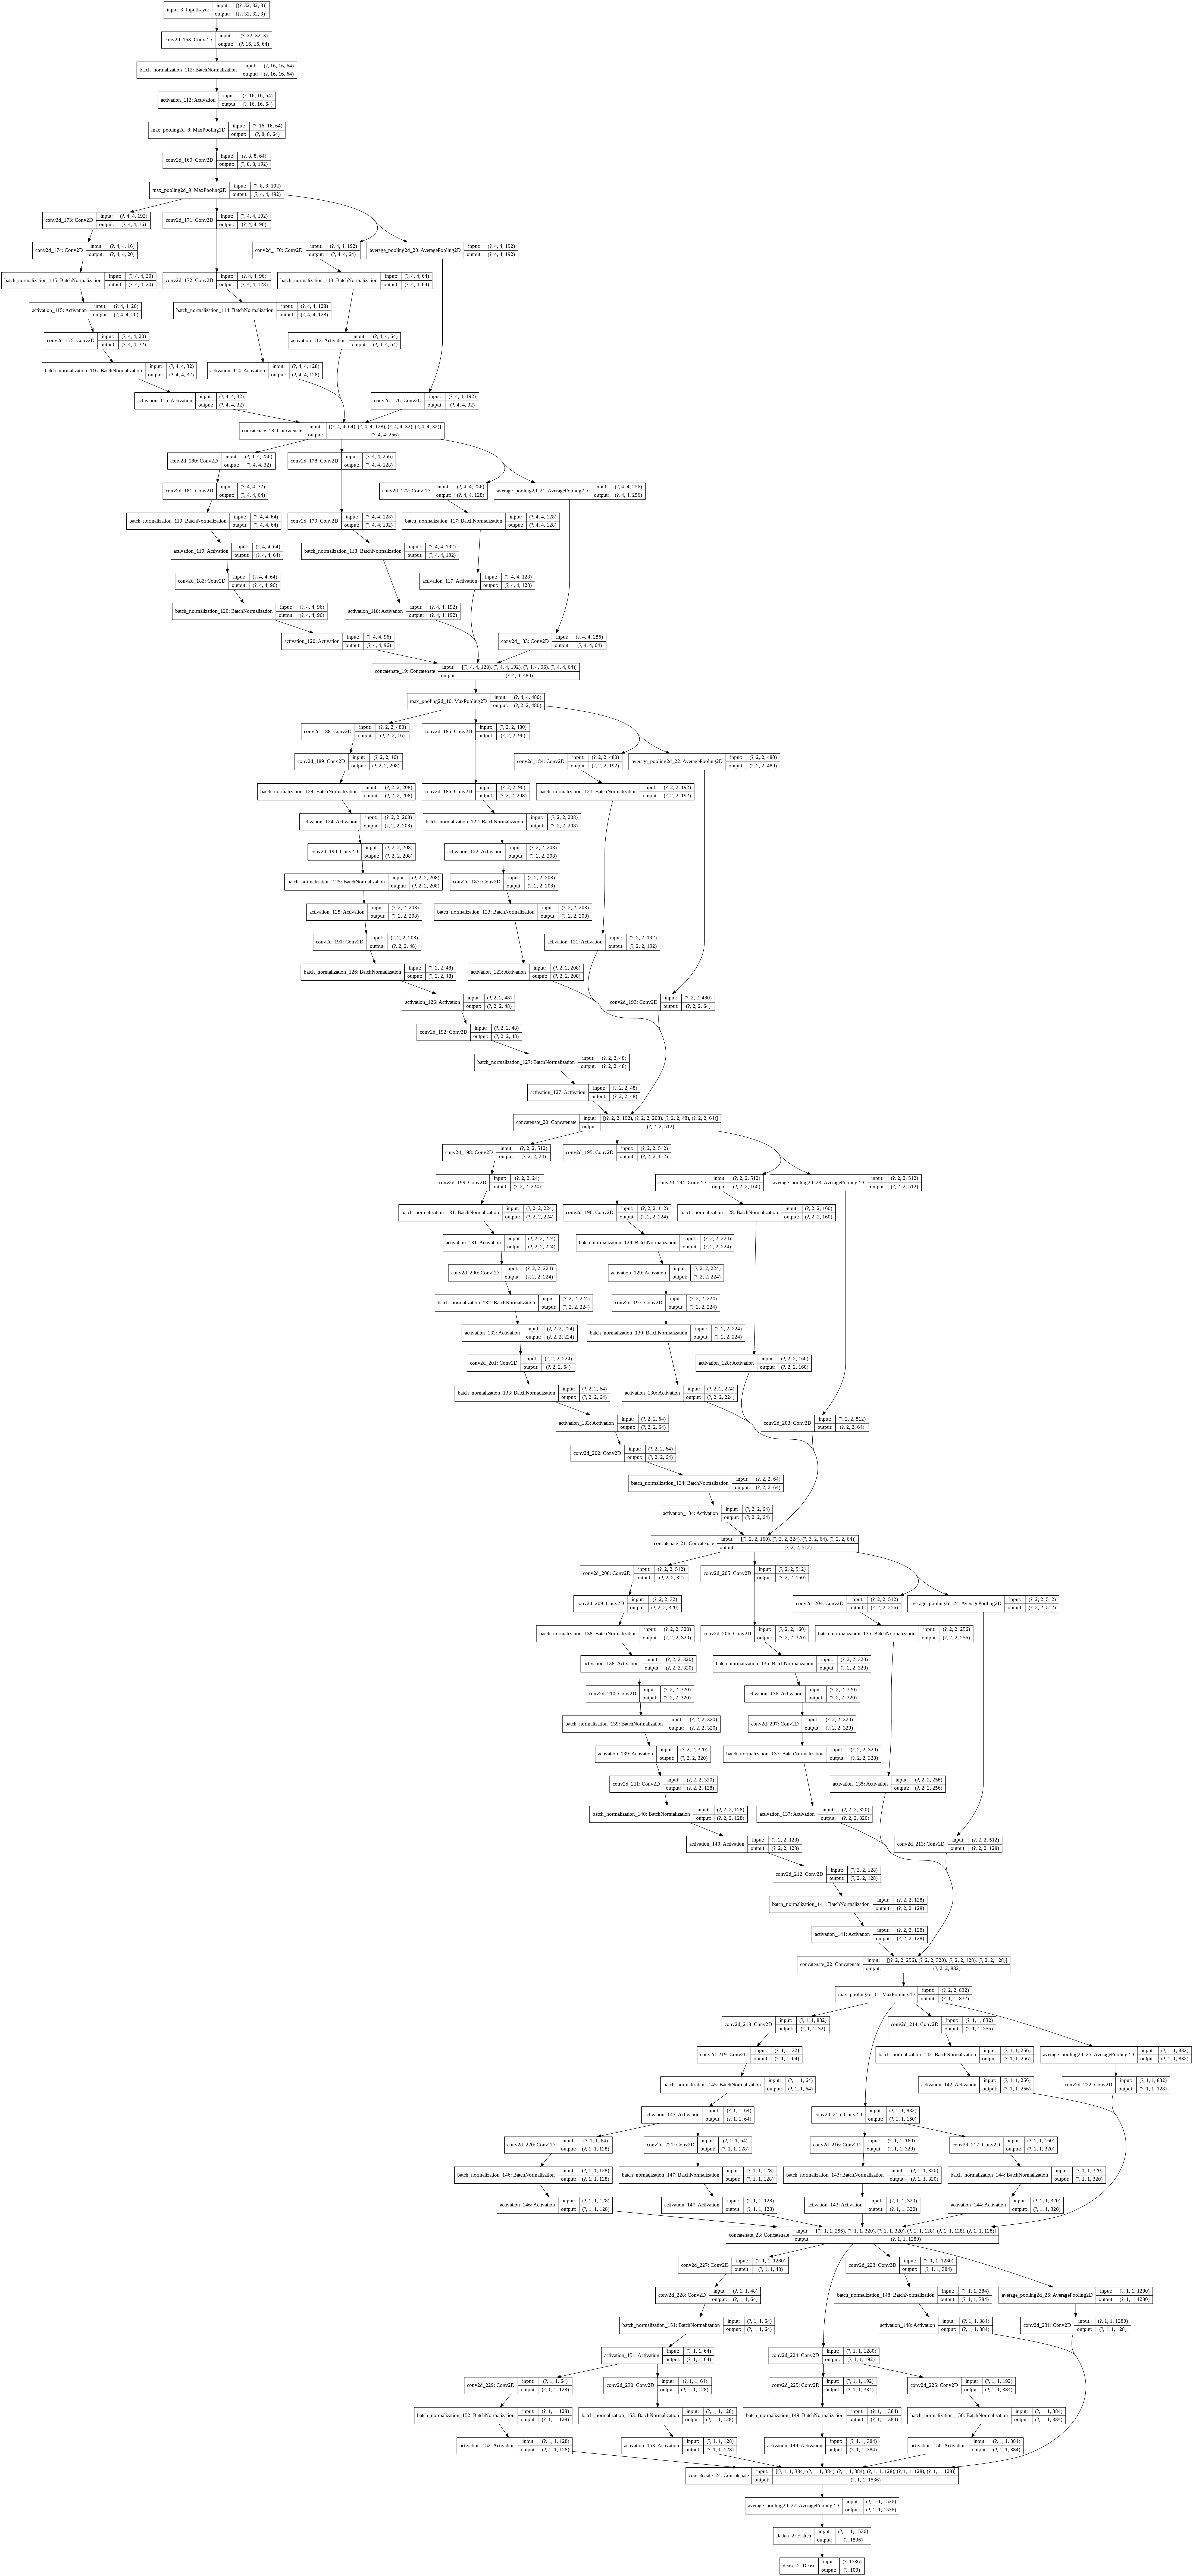

In [ ]:
model = create_model()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning rate 0.035 gave best results with decay 1e-5, accuracy dropped when lr/decay was increased
sgd = optimizers.SGD(lr=0.015, decay=1e-4,momentum=0.8) #lr=0.085
adam = optimizers.Adam(lr=0.0006, decay = 1e-3,clipvalue=0.5) #use epoch around 
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=20,mode='max')
checkpoint_path = "InceptionV2_SGD_BatchNormalization"
best_model = ModelCheckpoint(filepath = checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')

log_path = "logs/inception_BatchNormalization/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_path)
# batch size to 128 for best accuracy, it decreases if batch size is increased
history = model.fit(datagen.flow(x_train, y_train,
                                batch_size=128),
                    steps_per_epoch=x_train.shape[0] // 128,
                    epochs=250,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping,best_model,tensorboard],verbose=2)
# history = model.fit(x_train, y_train,
#                     batch_size= 128,
#                     epochs=250,
#                     validation_data=(x_test, y_test),
#                     callbacks=[early_stopping,best_model,tensorboard],verbose=2)

Epoch 1/250
390/390 - 30s - loss: 13.3863 - accuracy: 0.0673 - val_loss: 12.8165 - val_accuracy: 0.0682
Epoch 2/250
390/390 - 28s - loss: 11.9521 - accuracy: 0.1294 - val_loss: 11.4227 - val_accuracy: 0.1523
Epoch 3/250
390/390 - 28s - loss: 10.8614 - accuracy: 0.1730 - val_loss: 10.4683 - val_accuracy: 0.1711
Epoch 4/250
390/390 - 28s - loss: 9.9803 - accuracy: 0.2013 - val_loss: 9.6721 - val_accuracy: 0.1973
Epoch 5/250
390/390 - 28s - loss: 9.2318 - accuracy: 0.2235 - val_loss: 9.1482 - val_accuracy: 0.1938
Epoch 6/250
390/390 - 28s - loss: 8.5757 - accuracy: 0.2451 - val_loss: 8.2277 - val_accuracy: 0.2686
Epoch 7/250
390/390 - 28s - loss: 7.9951 - accuracy: 0.2657 - val_loss: 7.9474 - val_accuracy: 0.2400
Epoch 8/250
390/390 - 28s - loss: 7.4977 - accuracy: 0.2797 - val_loss: 7.2763 - val_accuracy: 0.2810
Epoch 9/250
390/390 - 28s - loss: 7.0543 - accuracy: 0.2944 - val_loss: 6.8053 - val_accuracy: 0.3124
Epoch 10/250
390/390 - 28s - loss: 6.6464 - accuracy: 0.3105 - val_loss: 6.6

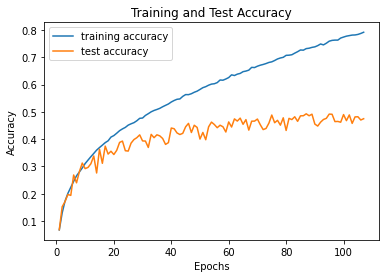

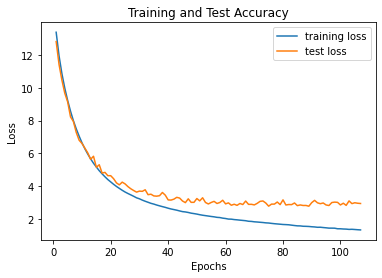

In [ ]:
#plot Accuracy vs epochs
train_metrics = history.history['accuracy']
val_metrics = history.history['val_accuracy']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training accuracy", 'test accuracy'])
plt.show()
#plot Validaiton loss vs epochs
train_metrics = history.history['loss']
val_metrics = history.history['val_loss']
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss", 'test loss'])
plt.show()

In [ ]:
model = create_model()
checkpoint_path = "../weights/InceptionV2_SGD_BatchNormalization"
model.load_weights(checkpoint_path)
# loss,acc = model.evaluate(x_test,  y_test, verbose=2)
# print('Test Accuracy:', acc)
cm = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
print(cm)
precision = precision_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

accuracy= accuracy_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
recall= recall_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

print('precision:', precision)
print('accuracy:', accuracy)
print('recall:', recall)

[[79  0  0 ...  0  0  0]
 [ 2 66  0 ...  0  0  0]
 [ 0  2 22 ...  0  2  0]
 ...
 [ 0  0  0 ... 39  0  1]
 [ 2  1  3 ...  0 14  0]
 [ 1  1  0 ...  0  0 66]]
precision: 0.5185047651868221
accuracy: 0.4929
recall: 0.4929


In [ ]:
%tensorboard --logdir logs/inception_BatchNormalization